## 11-23 RE 09 Sourcing & Analyzing Time-Series Data

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disabling deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for the plots' appearance. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# This option ensures the created charts will be displayed in the notebook without the need to "call" them specifically.

%matplotlib inline

In [3]:
# importing df
path=r'C:\Users\user\11-2023 Real Estate Sales Connecticut'
df=df_re=pd.read_csv(os.path.join(path,'Data','Prepared Data','realestate_sold.csv'), index_col=0)

In [4]:
df.head(5)

,Serial Number,List Year,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Year of Sale,Month of Sale,Sale_Amount_Zscore
0,2020348,2020,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,Non Residental,2021,9,-0.040765
1,20002,2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.5883,Residential,Single Family,2020,10,0.033112
2,200212,2020,Avon,5 CHESTNUT DRIVE,130400.0,179900.0,0.7248,Residential,Condo,2021,3,-0.142855
3,200243,2020,Avon,111 NORTHINGTON DRIVE,619290.0,890000.0,0.6958,Residential,Single Family,2021,4,0.356761
4,200377,2020,Avon,70 FAR HILLS DRIVE,862330.0,1447500.0,0.5957,Residential,Single Family,2021,7,0.749010


In [5]:
df.describe()

,Serial Number,List Year,Assessed Value,Sale Amount,Sales Ratio,Year of Sale,Month of Sale,Sale_Amount_Zscore
count,9.953670e+05,995367.000000,9.953670e+05,9.953670e+05,9.953670e+05,995367.000000,995367.000000,9.953670e+05
mean,4.315343e+05,2010.201700,2.781387e+05,3.829385e+05,1.046550e+01,2010.952809,6.812173,-2.147261e-17
std,6.550747e+06,6.235429,1.414069e+06,1.421291e+06,1.891944e+03,6.244898,3.236982,1.000000e+00
min,8.100000e+01,2001.000000,0.000000e+00,1.000000e+00,0.000000e+00,1999.000000,1.000000,-2.694294e-01
25%,3.045300e+04,2004.000000,8.770000e+04,1.400000e+05,4.875500e-01,2005.000000,4.000000,-1.709281e-01
50%,7.032700e+04,2010.000000,1.384600e+05,2.250000e+05,6.250857e-01,2011.000000,7.000000,-1.111233e-01
75%,1.600010e+05,2016.000000,2.256500e+05,3.650000e+05,7.858000e-01,2017.000000,9.000000,-1.262128e-02
max,2.000500e+09,2020.000000,1.428587e+08,2.300436e+08,1.226420e+06,2021.000000,12.000000,1.615860e+02


In [6]:
# First, let's combine the year and month columns into a single date column
# pd.offsets.MonthEnd(0) assigne the last date of month and not the first to the data. I need it to avoid missing values by future Decomposition by month ,
# which comprend only end of month data
df['date'] = pd.to_datetime(df['Year of Sale'].astype(str) + '-' + df['Month of Sale'].astype(str), format='%Y-%m')
df['date'] = df['date'].apply(lambda x: x + pd.offsets.MonthEnd(0))


In [7]:
df.head(2)

,Serial Number,List Year,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Year of Sale,Month of Sale,Sale_Amount_Zscore,date
0,2020348,2020,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,Non Residental,2021,9,-0.040765,2021-09-30
1,20002,2020,Ashford,390 TURNPIKE RD,253000.0,430000.0,0.5883,Residential,Single Family,2020,10,0.033112,2020-10-31


In [8]:
DF=df.groupby('date').sum('Sale Amount')

In [9]:
DF.shape

(243, 8)

In [10]:
DF.head(2)

,Serial Number,List Year,Assessed Value,Sale Amount,Sales Ratio,Year of Sale,Month of Sale,Sale_Amount_Zscore
date,,,,,,,,
1999-04-30,170177,2017,46690.0,95000.0,0.491400,1999,4,-0.202589
2001-08-31,346367,4034,818720.0,1193000.0,1.382313,4002,16,0.300518


# Creating time series

In [11]:
# Now 'Sale Amount' column becomes the time series
DFts = DF['Sale Amount']

In [12]:
DFts.head(2)

date
1999-04-30      95000.0
2001-08-31    1193000.0
Name: Sale Amount, dtype: float64

In [13]:
DFts.shape

(243,)

In [14]:
type(DFts)

pandas.core.series.Series

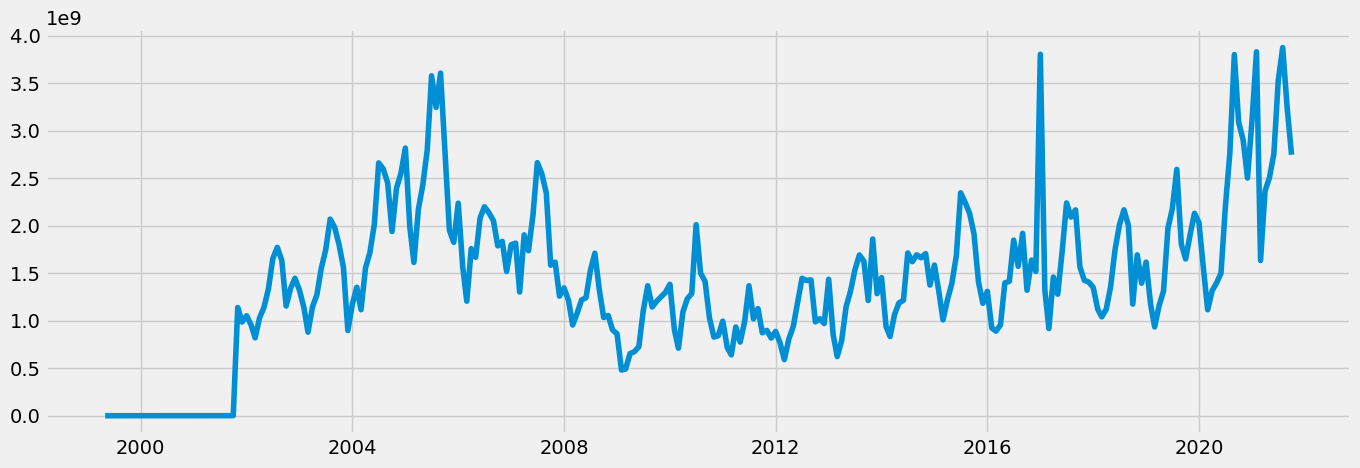

In [15]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(DFts)

### 2. Subsetting, wrangling, and cleaning time-series data

In [16]:
# Check for missing values (the dataset shouldn't have any)

DFts.isnull().sum() 

0

In [17]:
# Check for duplicates

dups = DFts.duplicated()
dups.sum()

# No dups!

0

In [18]:
### Check for missing values:

In [19]:
# Identify rows with missing values
missing_values = DFts[DFts.isnull()]
print(missing_values)


Series([], Name: Sale Amount, dtype: float64)


In [20]:
# Check for duplicate indices
duplicate_indices = DFts.index[DFts.index.duplicated()]
print(duplicate_indices)


DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)


In [21]:
 # Check for missing values
missing_values = DFts[DFts.isnull()]
print(missing_values)


Series([], Name: Sale Amount, dtype: float64)


In [22]:
DFts.shape

(243,)

In [23]:
DFts.head(2)

date
1999-04-30      95000.0
2001-08-31    1193000.0
Name: Sale Amount, dtype: float64

In [24]:
# Assuming your Series is named 'sales_series'
DFts.name = 'Sale_Amount'
DFts.index.name = 'Date'

In [25]:
DFts.head(2)

Date
1999-04-30      95000.0
2001-08-31    1193000.0
Name: Sale_Amount, dtype: float64

### 3. Time-series analysis: decomposition

In [26]:
# Assuming the start date and length of the time series
DFts.index = pd.date_range(start='1/1/1999', periods=len(DFts), freq='M') 
# Set the frequency to monthly
DFts.index.freq = 'M'  

# Now I can proceed with seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(DFts, model='additive')


In [27]:
from pylab import rcParams # This defines a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

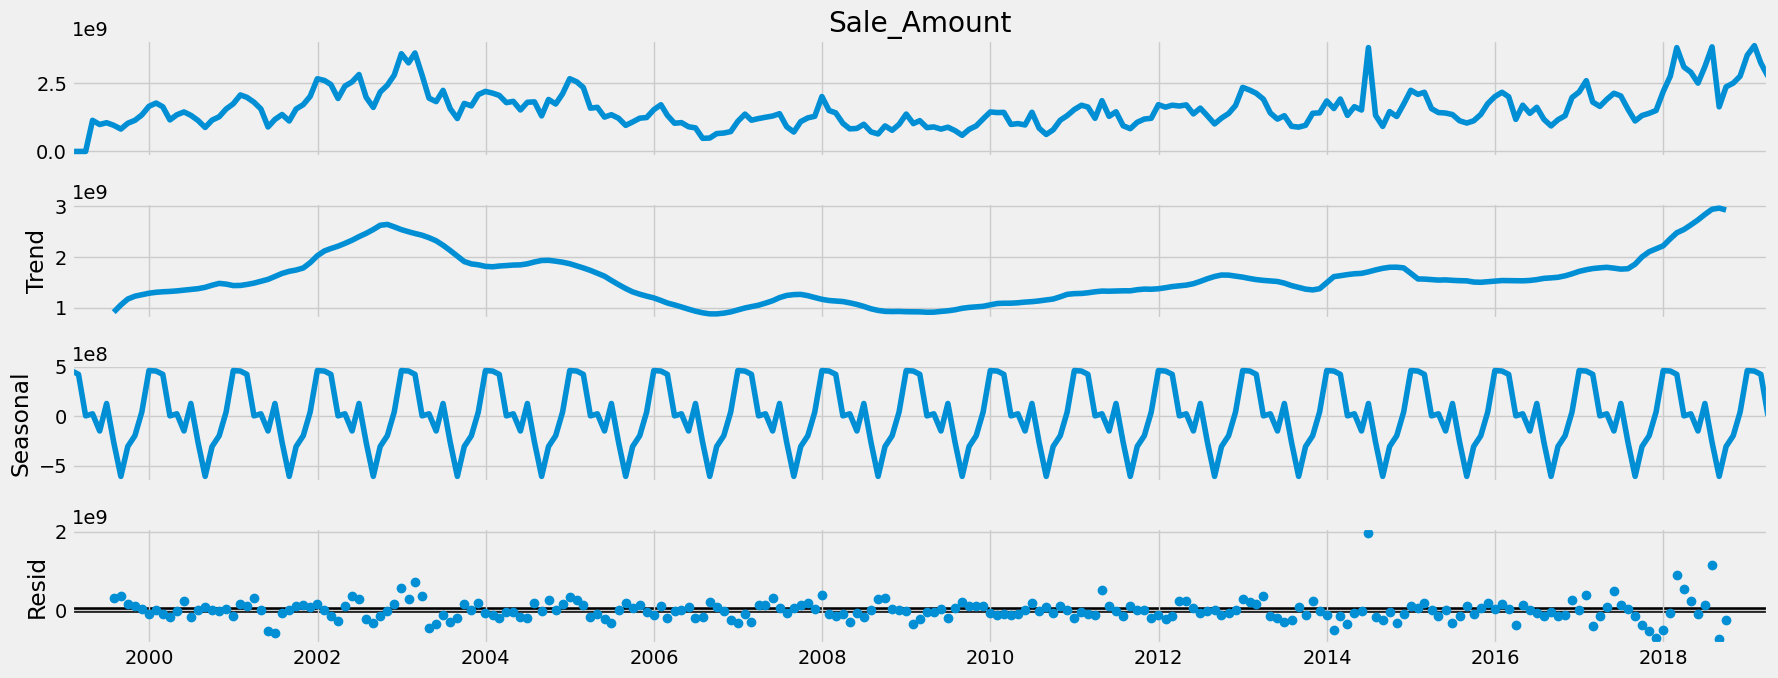

In [28]:
# Ploting the separate components

decomposition.plot()

plt.show()

### 4. Testing for stationarity

In [29]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why is needed also to define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(DFts)

Dickey-Fuller Stationarity test:
Test Statistic                  -1.330091
p-value                          0.615296
Number of Lags Used             14.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


#### The conclusion: Test Statistic >Critical Value (5%)  (-1.330091>-2.874302), the data is not stationarity. The p-value is > 0.05 which means the result is not significant

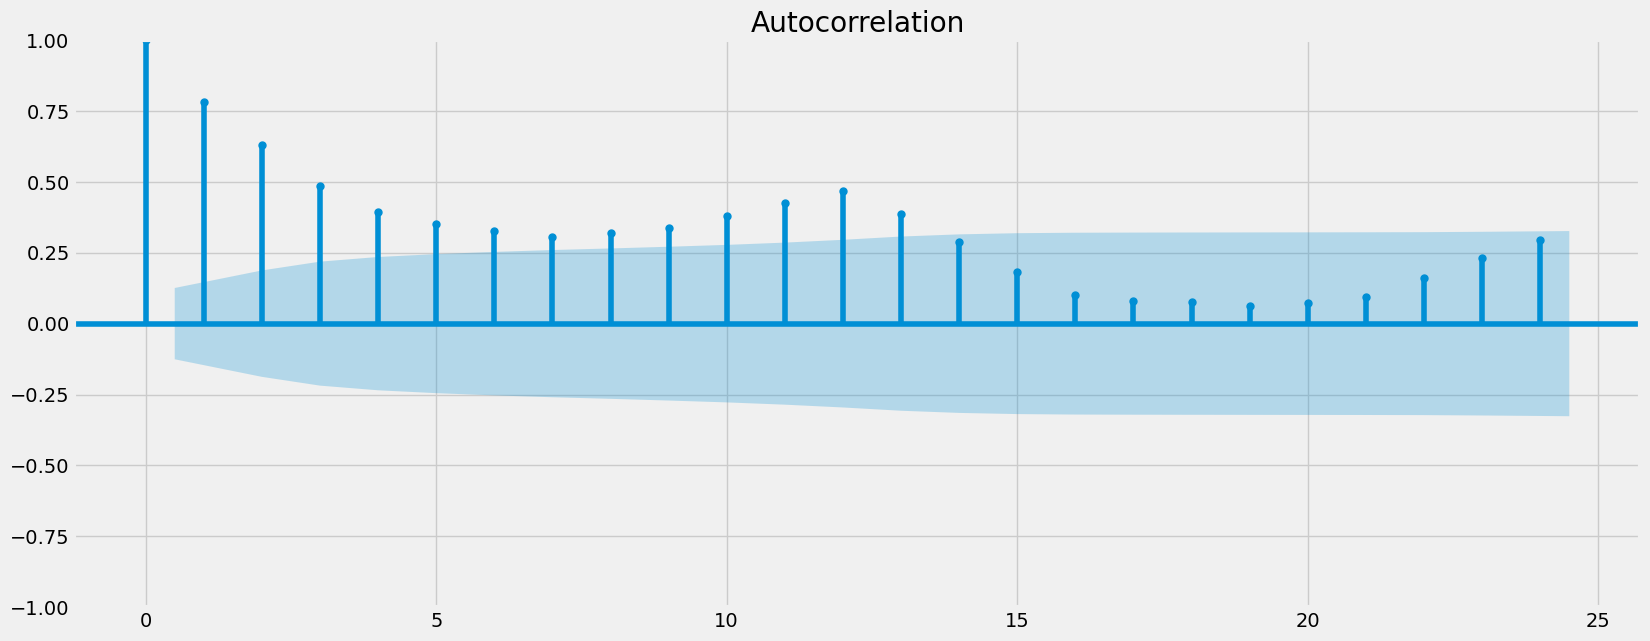

In [30]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, I am importing the autocorrelation and partial correlation plots

plot_acf(DFts)
plt.show()

### The conclusion: The vertical lines represent the lags in the series, while the blue area represents the confidence interval. 
### When lines go above the blue edge of the confidence interval, this means the lags are significantly correlated with each other. 
### And many lags beyond this interval, I deduce that the data is non-stationary. 
### This means there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test conducted earlier.

### 5. Stationarizing the  Data by differencing

In [31]:
data_diff = DFts - DFts.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [32]:
data_diff.dropna(inplace = True) # removing the missing values that came about as a result of the differencing. 
# I need to remove these or I won't be able to run the Dickey-Fuller test.

In [33]:
data_diff.head()

1999-02-28    1.098000e+06
1999-03-31   -5.552890e+05
1999-04-30    1.138322e+09
1999-05-31   -1.533498e+08
1999-06-30    6.630743e+07
Freq: M, Name: Sale_Amount, dtype: float64

In [34]:
data_diff.shape

(242,)

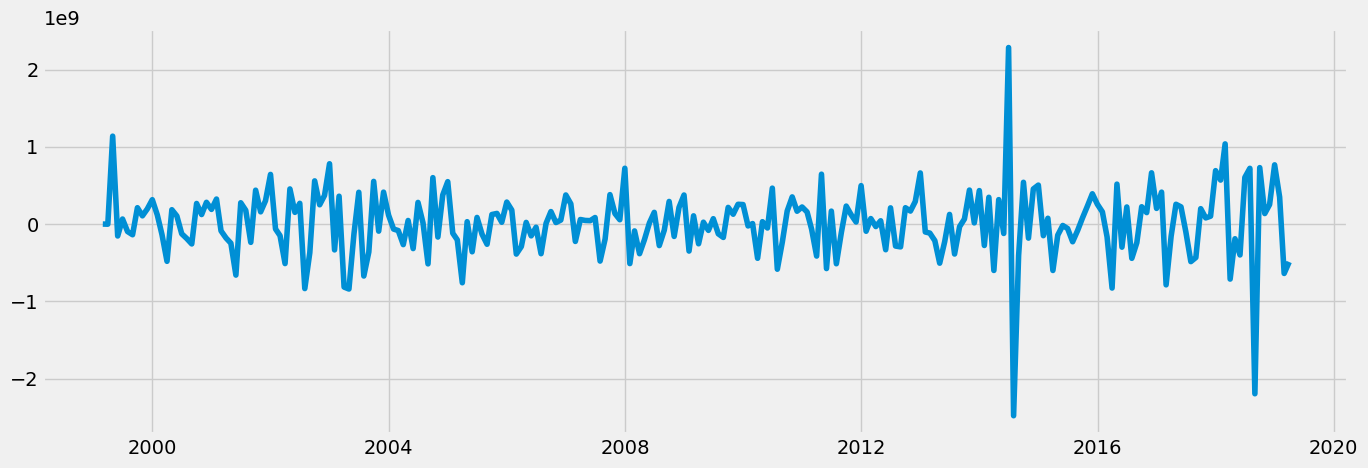

In [35]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [36]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -5.502653
p-value                          0.000002
Number of Lags Used             12.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


### Conclusions: Test Statistic <Critical Value (5%)  ( -5.502653<-2.874245), the data is stationarity. The p-value (0.000002) is < 0.05 that means the result is significant 

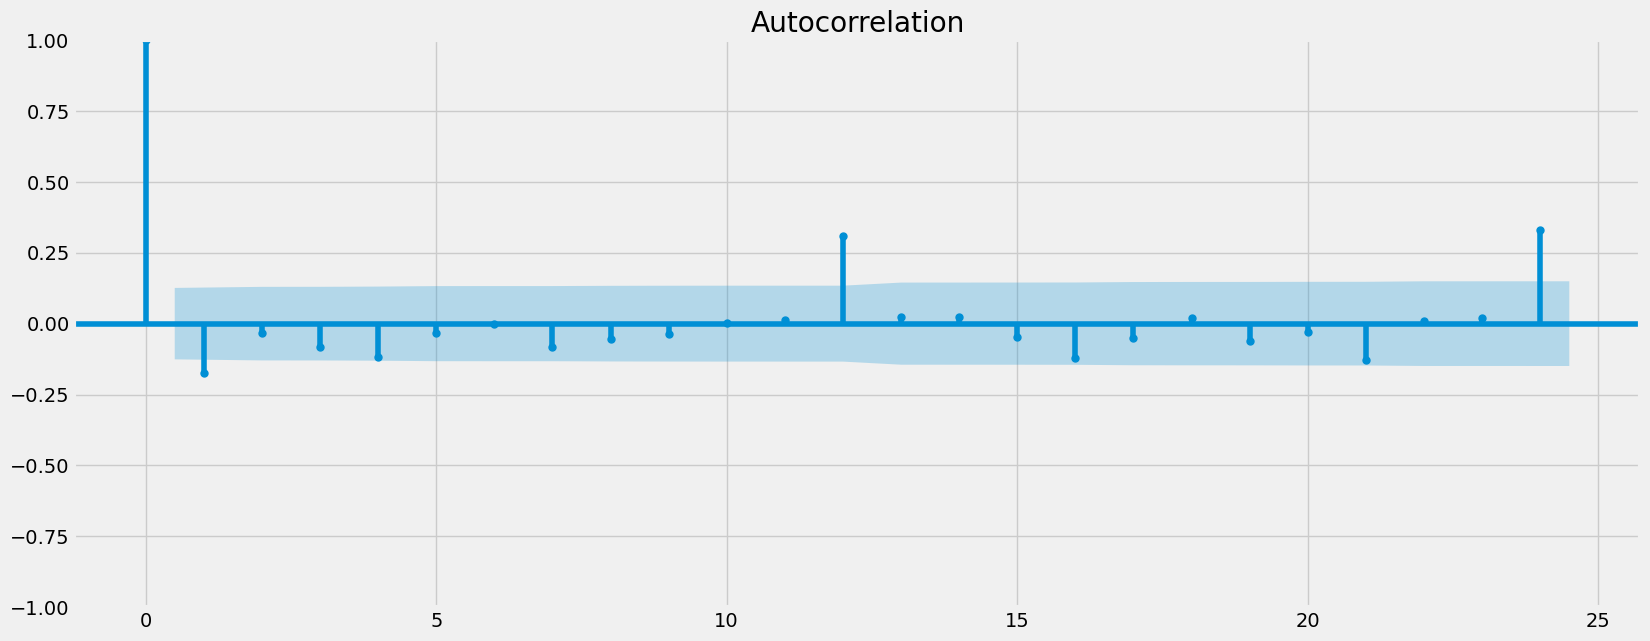

In [37]:
plot_acf(data_diff)
plt.show()

### Conclusions: there are 3 interval lags above the confidence intervale and one beyong it (less than ten significant lags). So, the data can be considerate stationary.

###  Time Series Forecasting in Python

### Defining parameters:

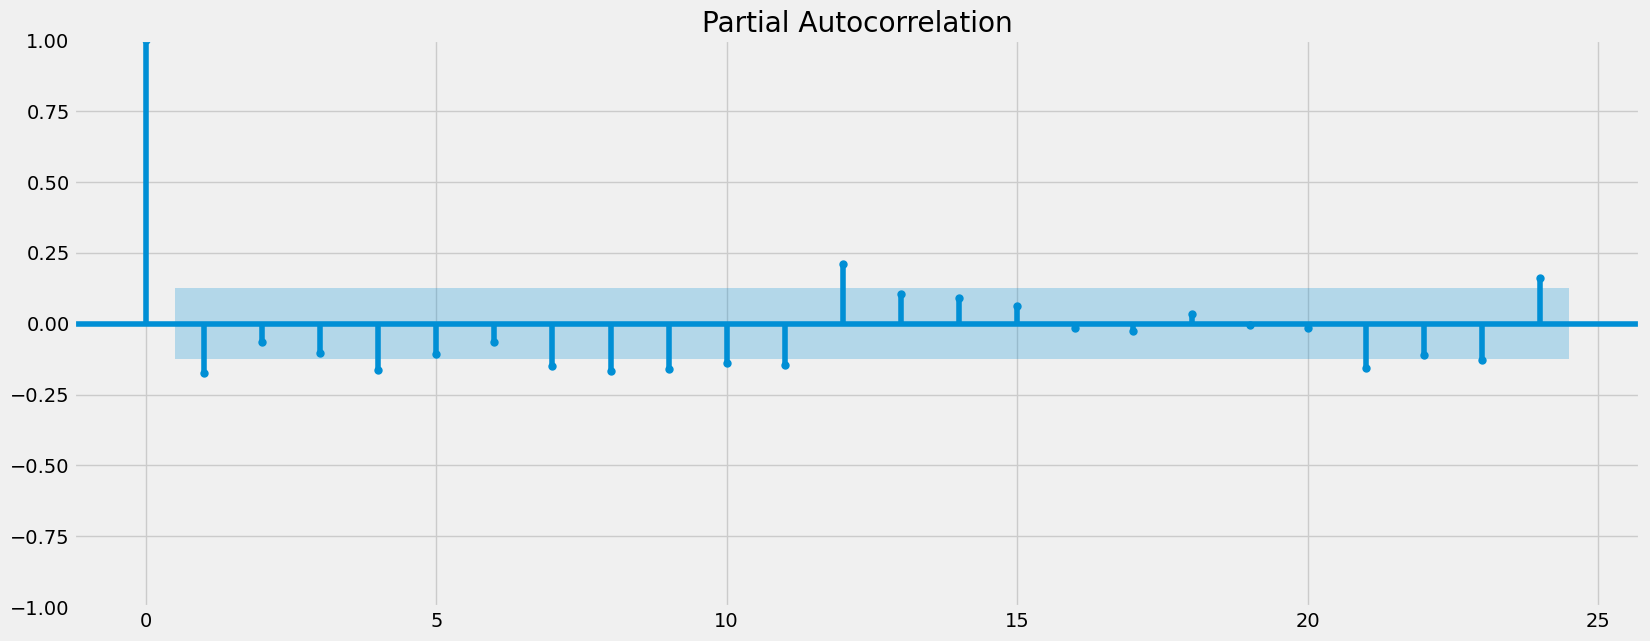

<Figure size 4500x4500 with 0 Axes>

In [38]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(data_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

### In the figure above, we have one highly positive bar and many bars above the confidence interval. These indicate significant correlations. Let’s start by picking 5 AR terms to compensate for the highest of the partial autocorrelations. This makes p = 5.

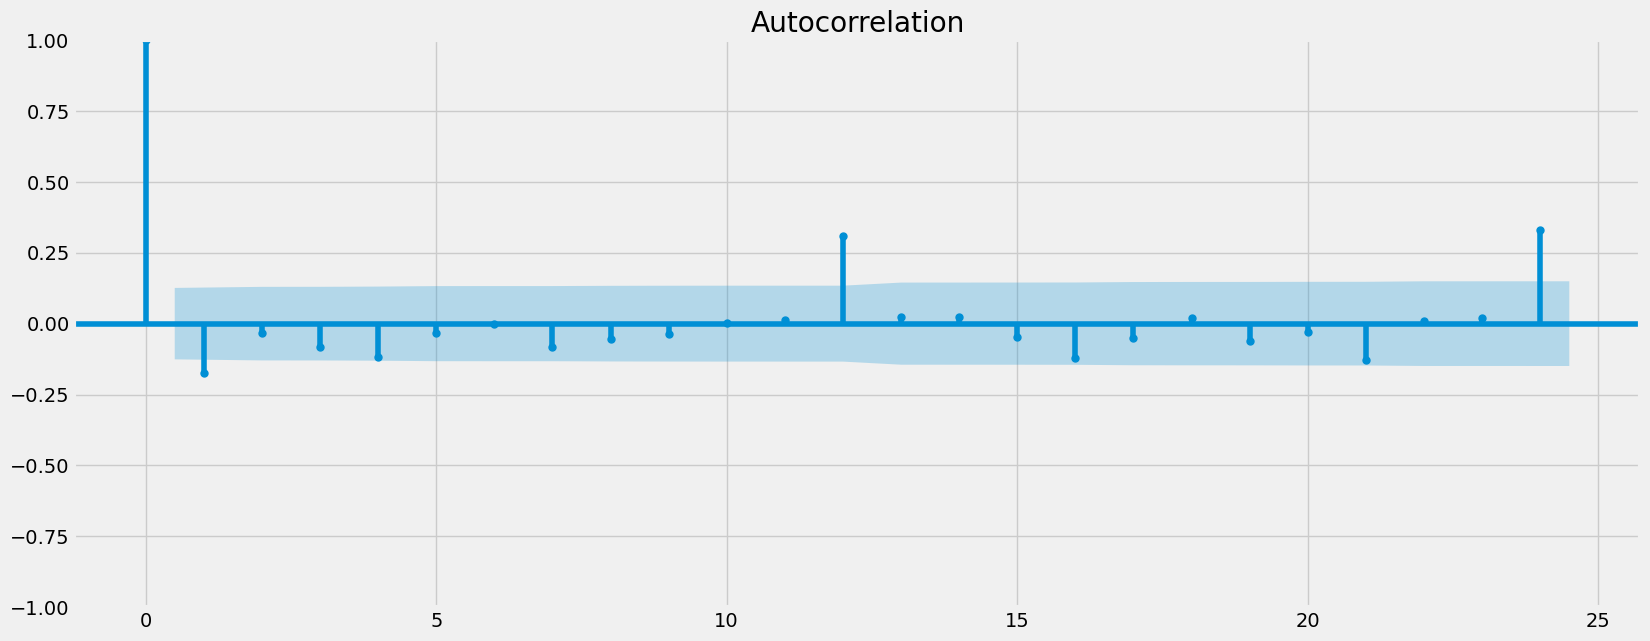

<Figure size 1500x500 with 0 Axes>

In [39]:
# Plot autocorrelations to determine parameter q

plot_acf(data_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

In [41]:
# It shows the significant autocorrelations here (those that run beyond the blue border), but for now, you can take a more conservative approach 
# and see what the output is like at q = 3.
# (It’s advisable to start with fewer terms as opposed to more and adjust accordingly further down the line as you begin testing the model.)

### Splitting the data

In [47]:
print(type(data_diff))

<class 'pandas.core.series.Series'>


In [48]:
data_diff_df = data_diff.to_frame()

In [50]:
# Split the data

train = data_diff_df['Sale_Amount'][:121]
test = data_diff_df['Sale_Amount'][120:]

In [51]:
data_diff_df.head()

,Sale_Amount
1999-02-28,1.098000e+06
1999-03-31,-5.552890e+05
1999-04-30,1.138322e+09
1999-05-31,-1.533498e+08
1999-06-30,6.630743e+07


In [53]:
# Checking the type of data_diff
print(type(data_diff_df))

# As data_diff is not a dataframe, converting it to a dataframe
if not isinstance(data_diff, pd.DataFrame):
    data_diff = data_diff.to_frame()

# Reseting the index to create a default integer index
data_diff = data_diff.reset_index()

# Spliting the data using the 'Sale_Amount' column
train = data_diff['Sale_Amount'][:121]
test = data_diff['Sale_Amount'][120:]


<class 'pandas.core.frame.DataFrame'>


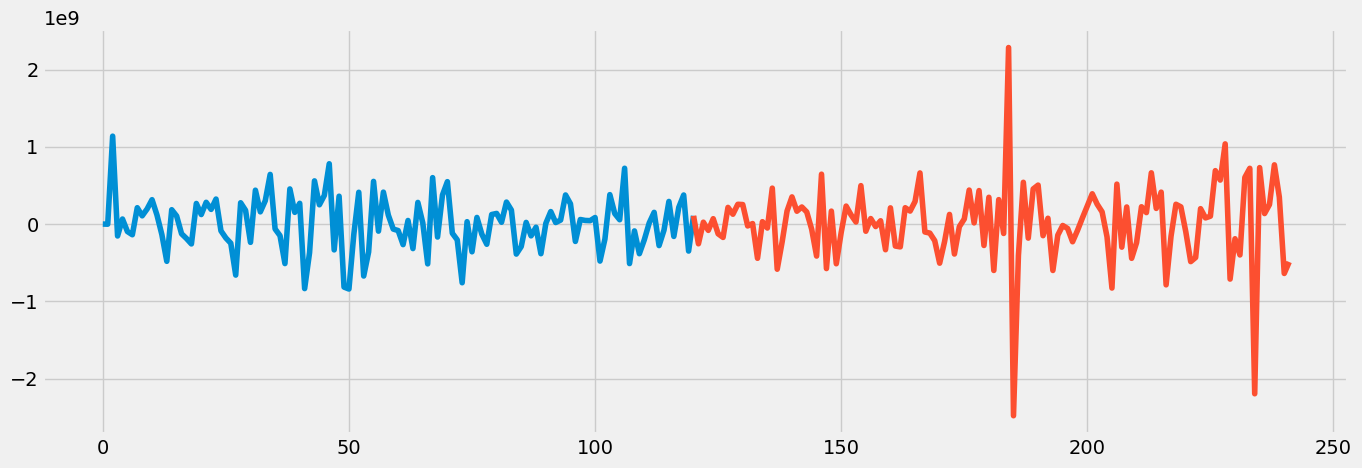

In [54]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [56]:
plt.savefig(os.path.join(path, 'Analytics', 'TimeseriesSplit.png'))

<Figure size 1800x700 with 0 Axes>

In [57]:
test.shape

(122,)

### 3. Running and Fitting the Model

In [62]:
from statsmodels.tsa.api import ARIMA # Importing the model 

                               SARIMAX Results                                
Dep. Variable:            Sale_Amount   No. Observations:                  121
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -2525.611
Date:                Tue, 02 Jan 2024   AIC                           5069.221
Time:                        21:35:54   BIC                           5094.309
Sample:                             0   HQIC                          5079.410
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2845      0.216     -1.320      0.187      -0.707       0.138
ar.L2          0.6369      0.208      3.067      0.002       0.230       1.044
ar.L3         -0.0418      0.124     -0.336      0.7

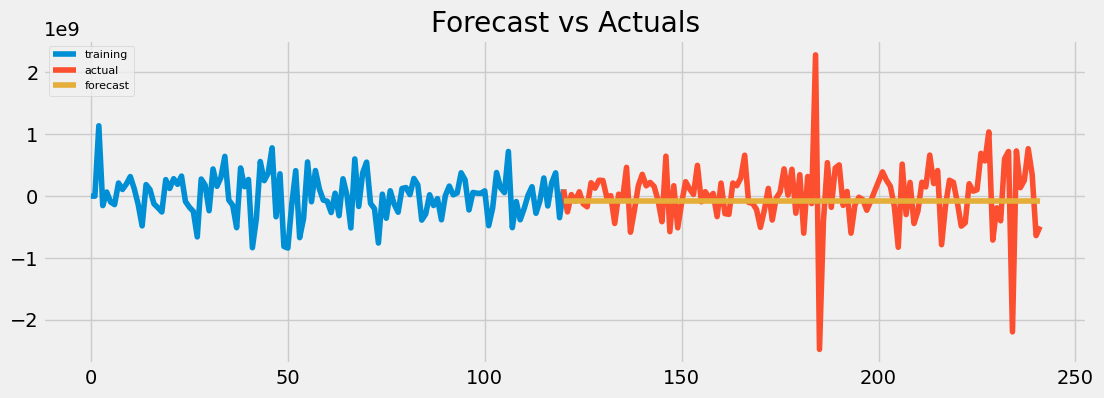

In [67]:
model = ARIMA(train, order=(5, 1, 3))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05;  

# Convert single float confidence interval to array
conf_array = np.array([conf, conf])

# Create pandas Series for the lower bound of the confidence interval
lower_series = pd.Series(np.full(len(test.index), conf_array[0]), index=test.index)

# Create pandas Series for the upper bound of the confidence interval
upper_series = pd.Series(np.full(len(test.index), conf_array[1]), index=test.index)

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig(os.path.join(path, 'Analytics', 'ARIMAmodel.png'))
plt.show()

###  The Ljung-Box (L1) (Q) statistic measures the presence of autocorrelation in the residuals of the model up to lag 1. In this case, the value of 0.01 indicates that there is little evidence of autocorrelation in the residuals up to lag 1.
### 
The Jarque-Bera (JB) statistic is a test of whether the data has the skewness and kurtosis matching a normal distribution. The reported JB value of 0.66 and its associated p-value of 0.72 suggest that the data is likely normally distributed.### 

The Prob(Q) value of 0.94 is the p-value associated with the Ljung-Box (Q) statistic, indicating that there is no significant evidence of residual autocorrelation in the mode### l.

The Prob(JB) value of 0.72 is the p-value associated with the Jarque-Bera (JB) statistic, indicating that the data is likely normally distribu### ted.

The Heteroskedasticity (H) value of 0.62 measures the variance of the residuals, where a value close to 1 suggests that the residuals have constant var### iance.

The Skew value of -0.13 measures the degree of asymmetry in the distribution of the residuals. A negative skewness indicates a slight left-skewed distribution of the re### siduals.

Overall, based on these statistics, the model appears to have residuals with little evidence of autocorrelation, is likely normally distributed, and has fairly constant variance. This suggests that the ARIMA model is a good fit for the data.  